## JOB-A-THON - September 2021 - Store Sales Prediction problem%md
## Model exploration

### Notebook setup

In [0]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

import mlflow
import mlflow.sklearn

In [0]:
# Setting pandas options for good visualization
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format',  '{:,.2f}'.format)
pd.set_option('display.max_info_columns', 30)

# seaborn style for chart visualization
sns.set_style("whitegrid")

### Creating datasets

In [0]:
# loading test dataset
# File location and type
file_location = "/FileStore/tables/TRAIN.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
train = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

train = train.toPandas()

In [0]:
# loading test dataset
# File location and type
file_location = "/FileStore/tables/TEST_FINAL.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
test = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

test = test.toPandas()

### Data preprocessing

In [0]:
###################### data preprocessing - train #######################
# reordering columns of train dataset
train = \
train[["ID","Sales","Store_id","Store_Type",
       "Location_Type","Region_Code","Date","Holiday",
       "Discount","#Order"
           ]]

# renaming feature names
train = train.rename(columns={"#Order":"Num_Order"})

# changing variable type 
# Store id : int -> object
#train["Store_id"] = train["Store_id"].astype('object')
# Date id : object -> Date
train["Date"] = pd.to_datetime(train["Date"])

# Recoding Discount column
discount = {"Yes":1, "No":0}
train["Discount"] = train["Discount"].map(discount)

###################### feature engineering - train #####################
# Creating date time features
train["Year"]= train["Date"].dt.year
train["Month"]= train["Date"].dt.month
train["Day"]= train["Date"].dt.day
train["Week_of_year"] = train["Date"].dt.week
train["Day_of_week"] = train["Date"].dt.dayofweek
train["Weekend"] = np.where(train["Day_of_week"].isin([5,6]), 1, 0)
train["Month_Start"] = train["Date"].dt.is_month_start.astype(int)
train["Month_End"] = train["Date"].dt.is_month_end.astype(int)
train["Quarter_Start"] = train["Date"].dt.is_quarter_start.astype(int)
train["Quarter_End"] = train["Date"].dt.is_quarter_end.astype(int)
train["Year_Start"] = train["Date"].dt.is_year_start.astype(int)
train["Year_End"] = train["Date"].dt.is_year_end.astype(int)
train['Period'] = train['Date'].dt.strftime('%Y%m').astype(int)

# One-Hot Encoding (Dummy Encoding)
ohe_cols = ["Store_Type", "Location_Type", "Region_Code", "Day_of_week"]
train["Day_of_week"] = train["Day_of_week"].astype(object)
train = \
pd.concat([train.drop(ohe_cols, axis = 1), 
           pd.get_dummies(train[ohe_cols], prefix = ohe_cols)], axis = 1)

<command-3935326977358198>:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train["Week_of_year"] = train["Date"].dt.week


In [0]:
###################### data preprocessing - tets ########################

# changing variable type 
# Store id : int -> object
# test["Store_id"] = test["Store_id"].astype('object')
# Date id : object -> Date
test["Date"] = pd.to_datetime(test["Date"])

# Recoding Discount column
discount = {"Yes":1, "No":0}
test["Discount"] = test["Discount"].map(discount)

###################### feature engineering - test #######################

test["Year"]= test["Date"].dt.year
test["Month"]= test["Date"].dt.month
test["Day"]= test["Date"].dt.day
test["Week_of_year"] = test["Date"].dt.week
test["Day_of_week"] = test["Date"].dt.dayofweek
test["Weekend"] = np.where(test["Day_of_week"].isin([5,6]), 1, 0)
test["Month_Start"] = test["Date"].dt.is_month_start.astype(int)
test["Month_End"] = test["Date"].dt.is_month_end.astype(int)
test["Quarter_Start"] = test["Date"].dt.is_quarter_start.astype(int)
test["Quarter_End"] = test["Date"].dt.is_quarter_end.astype(int)
test["Year_Start"] = test["Date"].dt.is_year_start.astype(int)
test["Year_End"] = test["Date"].dt.is_year_end.astype(int)
test['Period'] = test['Date'].dt.strftime('%Y%m').astype(int)

# One-Hot Encoding (Dummy Encoding)
ohe_cols = ["Store_Type", "Location_Type", "Region_Code", "Day_of_week"]
test["Day_of_week"] = test["Day_of_week"].astype(object)
test = \
    pd.concat([test.drop(ohe_cols, axis = 1), 
    pd.get_dummies(test[ohe_cols], prefix = ohe_cols)], axis = 1)

<command-3935326977358201>:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test["Week_of_year"] = test["Date"].dt.week


In [0]:
train.head()

,ID,Sales,Store_id,Date,Holiday,Discount,Num_Order,Year,Month,Day,Week_of_year,Weekend,Month_Start,Month_End,Quarter_Start,Quarter_End,Year_Start,Year_End,Period,Store_Type_S1,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4,Day_of_week_0,Day_of_week_1,Day_of_week_2,Day_of_week_3,Day_of_week_4,Day_of_week_5,Day_of_week_6
0,T1000001,"7,011.84",1,2018-01-01,1,1,9,2018,1,1,1,0,1,0,1,0,1,0,201801,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
1,T1000002,"51,789.12",253,2018-01-01,1,1,60,2018,1,1,1,0,1,0,1,0,1,0,201801,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,T1000003,"36,868.20",252,2018-01-01,1,1,42,2018,1,1,1,0,1,0,1,0,1,0,201801,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,T1000004,"19,715.16",251,2018-01-01,1,1,23,2018,1,1,1,0,1,0,1,0,1,0,201801,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
4,T1000005,"45,614.52",250,2018-01-01,1,1,62,2018,1,1,1,0,1,0,1,0,1,0,201801,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0


### Model building

#### Creating train and test dataset

In [0]:
train_df = train[train["Period"] <= 201903]
val_df = train[train["Period"] > 201903]

print("Shape of train_df :", train_df.shape)
print("Shape of val_df :", val_df.shape)

Shape of train_df : (166075, 39)
Shape of val_df : (22265, 39)


#### Creating X and y

In [0]:
# Creating X and y
X_train = train_df.drop(["ID", "Sales", "Date", "Num_Order", "Period"], axis = 1)
y_train = train_df["Sales"].values

X_val = val_df.drop(["ID", "Sales", "Date", "Num_Order", "Period"], axis = 1)
y_val = val_df["Sales"].values

print("Shape of X_train :", X_train.shape)
print("Shape of X_val :", X_val.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of y_val :", y_val.shape)

Shape of X_train : (166075, 34)
Shape of X_val : (22265, 34)
Shape of y_train : (166075,)
Shape of y_val : (22265,)


#### Fit model

training score : 40.698859079015286
validation score : 101.82309540864044


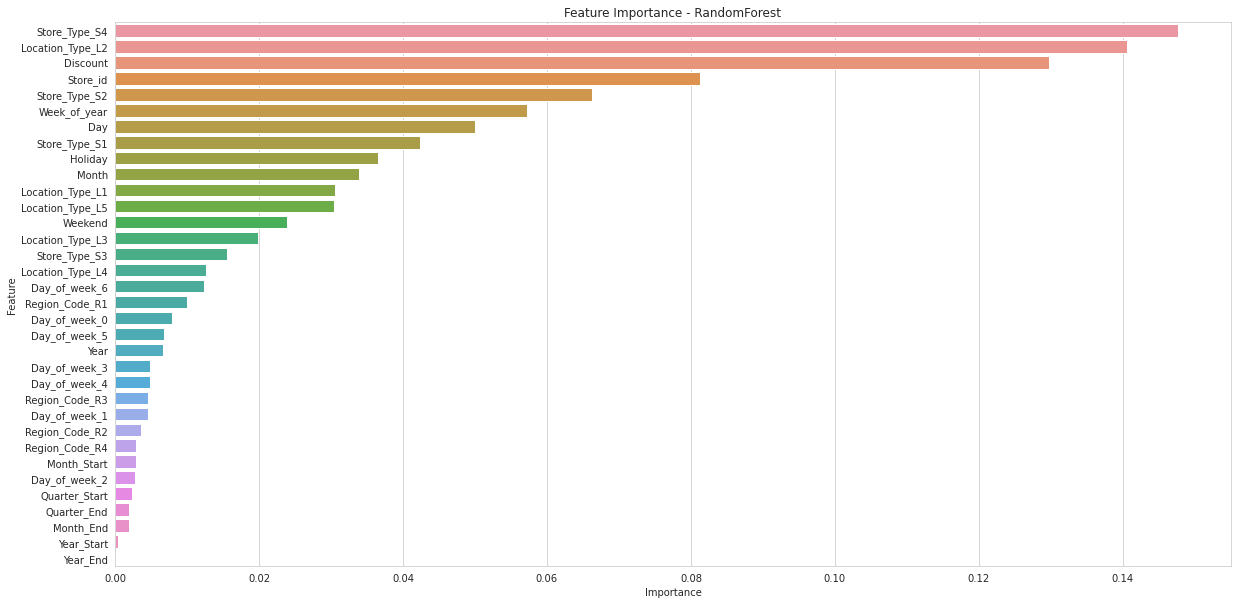

In [0]:
# logging model - RandomForest
with mlflow.start_run(run_name = "untuned_random_forest"):
  
  # RandomForest Regression model
  rf_reg_model = \
  Pipeline([('Scaler', StandardScaler()), 
            ('model', RandomForestRegressor(n_estimators = 500, 
                                            min_samples_leaf = 3,
                                            max_features = 'sqrt',
                                            n_jobs = -1,
                                            random_state = 123))
                                                ])

  # fit model
  rf_reg_model = rf_reg_model.fit(X_train, y_train)

  # making prediction
  train_pred = rf_reg_model.predict(X_train)
  val_pred = rf_reg_model.predict(X_val)

  # calculating score
  train_score = mean_squared_log_error(y_train, train_pred) * 1000
  val_score = mean_squared_log_error(y_val,val_pred) * 1000
  print("training score :", train_score)
  print("validation score :", val_score)

  # Feature importance plot
  importance = rf_reg_model.named_steps["model"].feature_importances_.tolist()
  feature_list = X_train.columns.tolist()

  importance_df = pd.DataFrame()
  importance_df["Feature"] = feature_list
  importance_df["Importance"] = importance

  importance_df = importance_df.sort_values(by = "Importance", ascending = False)

  plt.figure(figsize = (20,10))
  plt.title("Feature Importance - RandomForest")
  sns.barplot(x="Importance", y="Feature", data = importance_df);

  # log hyperparamaters
  mlflow.log_param("n_estimators", 500)
  mlflow.log_param("min_samples_leaf", 3)
  mlflow.log_param("max_features", "sqrt")
  mlflow.log_param("n_jobs", -1)
  mlflow.log_param("random_state", 123)

  # log metric
  mlflow.log_metric("Training MSLE", train_score) 
  mlflow.log_metric("Validation MSLE", val_score)
  
  # log model
  mlflow.sklearn.log_model(rf_reg_model, "RandomForest")

training score : 81.1397691128876
validation score : 106.2574840677107


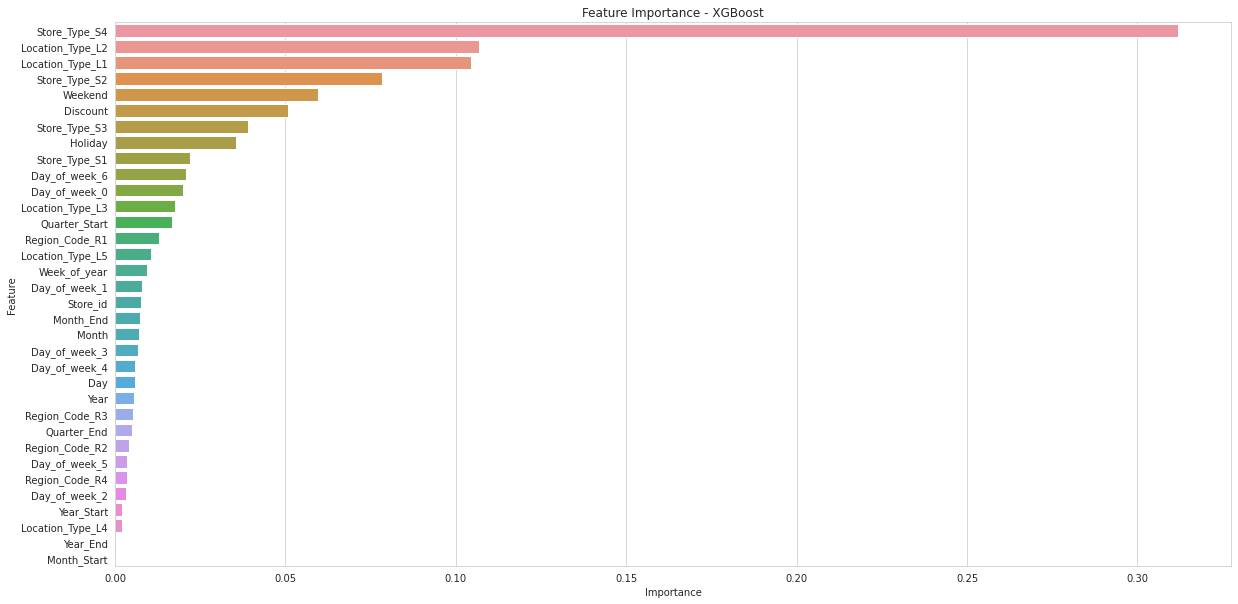

In [0]:
# logging model - XGBoost
from xgboost import XGBRegressor
with mlflow.start_run(run_name = "untuned_xgboost"):
  
  # RandomForest Regression model
  xgb_model = \
  Pipeline([('Scaler', StandardScaler()), 
            ('model', XGBRegressor(
              objective = 'reg:squarederror',
              n_estimators = 500,
              seed = 123,
              random_state = 123))
           ])

  # fit model
  xgb_model = xgb_model.fit(X_train, y_train)

  # making prediction
  train_pred = xgb_model.predict(X_train)
  val_pred = xgb_model.predict(X_val)
  
  train_pred[np.where(train_pred<0)] = 0
  val_pred[np.where(val_pred<0)] = 0
  # calculating score
  train_score = mean_squared_log_error(y_train, train_pred) * 1000
  val_score = mean_squared_log_error(y_val,val_pred) * 1000
  print("training score :", train_score)
  print("validation score :", val_score)

  # Feature importance plot
  importance = xgb_model.named_steps["model"].feature_importances_.tolist()
  feature_list = X_train.columns.tolist()

  importance_df = pd.DataFrame()
  importance_df["Feature"] = feature_list
  importance_df["Importance"] = importance

  importance_df = importance_df.sort_values(by = "Importance", ascending = False)

  plt.figure(figsize = (20,10))
  plt.title("Feature Importance - XGBoost")
  sns.barplot(x="Importance", y="Feature", data = importance_df);

  # log hyperparamaters
  mlflow.log_param("n_estimators", 1000)
  mlflow.log_param("objective", 'reg:squaredlogerror')
  mlflow.log_param("eval_metric", 'rmsle')
  mlflow.log_param("seed", 123)
  mlflow.log_param("random_state", 123)

  # log metric
  mlflow.log_metric("Training MSLE", train_score) 
  mlflow.log_metric("Validation MSLE", val_score)
  
  # log model
  mlflow.sklearn.log_model(xgb_model, "XGBoost")

training score : 36.73193301347758
validation score : 105.74739749345557


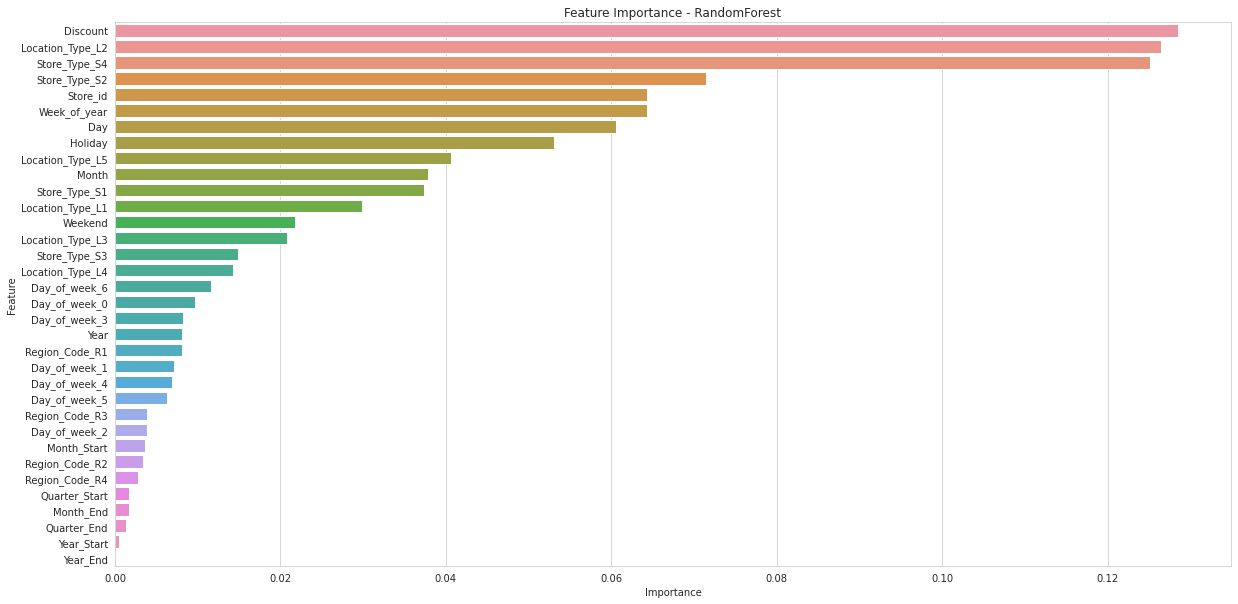

In [0]:
# logging model - RandomForest with target transformed using box-cox
with mlflow.start_run(run_name = "untuned_random_forest_target_transformed"):
  
  # transforming target variable using box-cox transformation
  from sklearn.preprocessing import PowerTransformer
  bc = PowerTransformer().fit(y_train.reshape(-1, 1))
  y_train_trans_bc = bc.transform(y_train.reshape(-1, 1)).ravel()
  y_val_trans_bc = bc.transform(y_val.reshape(-1, 1)).ravel()
  
  # RandomForest Regression model
  rf_reg_model = \
  Pipeline([('Scaler', StandardScaler()), 
            ('model', RandomForestRegressor(n_estimators = 500, 
                                            min_samples_leaf = 3,
                                            max_features = 'sqrt',
                                            n_jobs = -1,
                                            random_state = 123))
                                                ])

  # fit model
  rf_reg_model = rf_reg_model.fit(X_train, y_train_trans_bc)

  # making prediction
  train_pred = rf_reg_model.predict(X_train)
  val_pred = rf_reg_model.predict(X_val)
  
  train_pred = bc.inverse_transform(train_pred.reshape(-1, 1))
  val_pred = bc.inverse_transform(val_pred.reshape(-1, 1))
  
  # calculating score
  train_score = mean_squared_log_error(y_train, train_pred) * 1000
  val_score = mean_squared_log_error(y_val,val_pred) * 1000
  print("training score :", train_score)
  print("validation score :", val_score)

  # Feature importance plot
  importance = rf_reg_model.named_steps["model"].feature_importances_.tolist()
  feature_list = X_train.columns.tolist()

  importance_df = pd.DataFrame()
  importance_df["Feature"] = feature_list
  importance_df["Importance"] = importance

  importance_df = importance_df.sort_values(by = "Importance", ascending = False)

  plt.figure(figsize = (20,10))
  plt.title("Feature Importance - RandomForest")
  sns.barplot(x="Importance", y="Feature", data = importance_df);

  # log hyperparamaters
  mlflow.log_param("n_estimators", 500)
  mlflow.log_param("min_samples_leaf", 3)
  mlflow.log_param("max_features", "sqrt")
  mlflow.log_param("n_jobs", -1)
  mlflow.log_param("random_state", 123)

  # log metric
  mlflow.log_metric("Training MSLE", train_score) 
  mlflow.log_metric("Validation MSLE", val_score)
  
  # log model
  mlflow.sklearn.log_model(rf_reg_model, "RandomForest")

training score : 36.98973556815518
validation score : 105.13874488390333


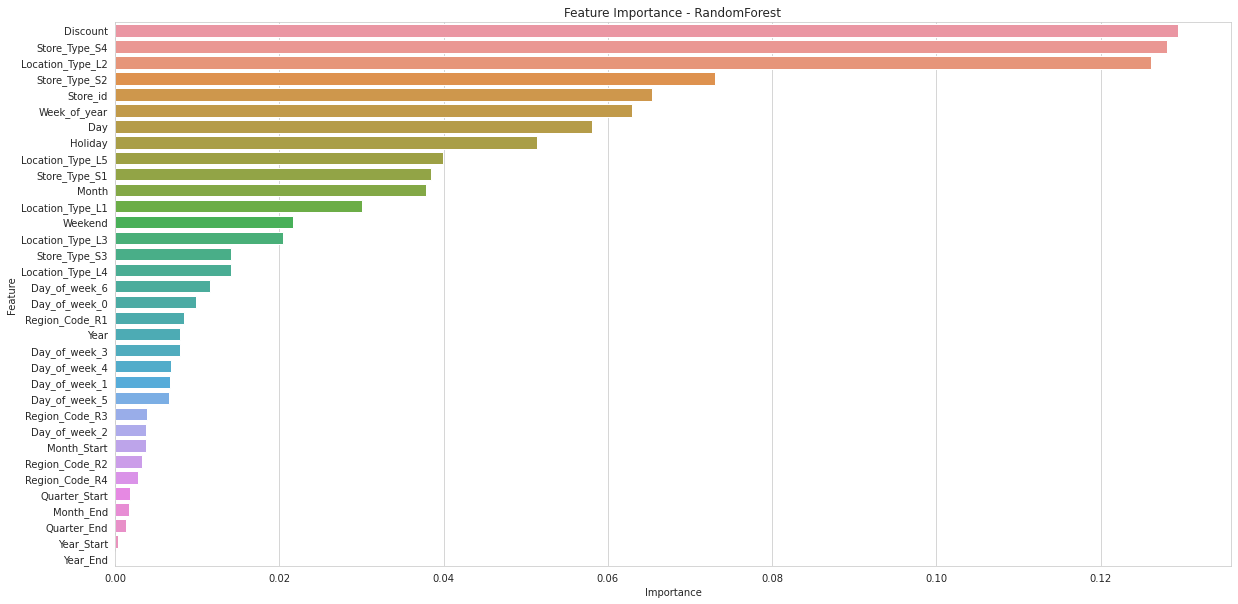

In [0]:
# logging model - RandomForest with target transformed using sqrt transformation
with mlflow.start_run(run_name = "untuned_random_forest_target_sqrt_transformed"):
  
  # transforming target variable using sqrt transformation
  y_train_sq_trans = np.sqrt(y_train)
  
  # RandomForest Regression model
  rf_reg_model = \
  Pipeline([('Scaler', StandardScaler()), 
            ('model', RandomForestRegressor(n_estimators = 500, 
                                            min_samples_leaf = 3,
                                            max_features = 'sqrt',
                                            n_jobs = -1,
                                            random_state = 123))
                                                ])

  # fit model
  rf_reg_model = rf_reg_model.fit(X_train, y_train_sq_trans)

  # making prediction
  train_pred = np.square(rf_reg_model.predict(X_train))
  val_pred = np.square(rf_reg_model.predict(X_val))
  
  # calculating score
  train_score = mean_squared_log_error(y_train, train_pred) * 1000
  val_score = mean_squared_log_error(y_val,val_pred) * 1000
  print("training score :", train_score)
  print("validation score :", val_score)

  # Feature importance plot
  importance = rf_reg_model.named_steps["model"].feature_importances_.tolist()
  feature_list = X_train.columns.tolist()

  importance_df = pd.DataFrame()
  importance_df["Feature"] = feature_list
  importance_df["Importance"] = importance

  importance_df = importance_df.sort_values(by = "Importance", ascending = False)

  plt.figure(figsize = (20,10))
  plt.title("Feature Importance - RandomForest")
  sns.barplot(x="Importance", y="Feature", data = importance_df);

  # log hyperparamaters
  mlflow.log_param("n_estimators", 500)
  mlflow.log_param("min_samples_leaf", 3)
  mlflow.log_param("max_features", "sqrt")
  mlflow.log_param("n_jobs", -1)
  mlflow.log_param("random_state", 123)

  # log metric
  mlflow.log_metric("Training MSLE", train_score) 
  mlflow.log_metric("Validation MSLE", val_score)
  
  # log model
  mlflow.sklearn.log_model(rf_reg_model, "RandomForest")

training score : 39.26562942703965


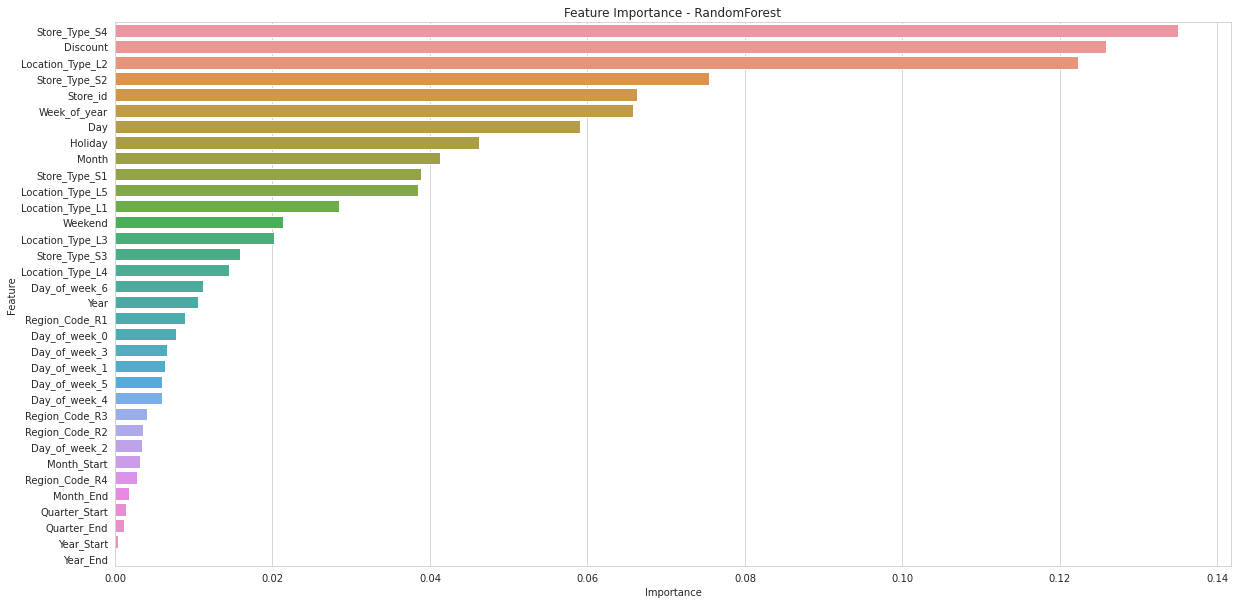

In [0]:
# logging model - RandomForest with target transformed using box-cox
with mlflow.start_run(run_name = "random_forest_target_sqrt_transformed_full"):
  
  # Creating X and y
  X_train = train.drop(["ID", "Sales", "Date", "Num_Order", "Period"], axis = 1)
  y_train = train["Sales"].values
  
  # transforming target variable using sqrt transformation
  y_train_sq_trans = np.sqrt(y_train)
  
  # RandomForest Regression model
  rf_reg_model = \
  Pipeline([('Scaler', StandardScaler()), 
            ('model', RandomForestRegressor(n_estimators = 500, 
                                            min_samples_leaf = 3,
                                            max_features = 'sqrt',
                                            n_jobs = -1,
                                            random_state = 123))
                                                ])

  # fit model
  rf_reg_model = rf_reg_model.fit(X_train, y_train_sq_trans)

  # making prediction
  train_pred = np.square(rf_reg_model.predict(X_train))
  
  # calculating score
  train_score = mean_squared_log_error(y_train, train_pred) * 1000
  print("training score :", train_score)

  # Feature importance plot
  importance = rf_reg_model.named_steps["model"].feature_importances_.tolist()
  feature_list = X_train.columns.tolist()

  importance_df = pd.DataFrame()
  importance_df["Feature"] = feature_list
  importance_df["Importance"] = importance

  importance_df = importance_df.sort_values(by = "Importance", ascending = False)

  plt.figure(figsize = (20,10))
  plt.title("Feature Importance - RandomForest")
  sns.barplot(x="Importance", y="Feature", data = importance_df);

  # log hyperparamaters
  mlflow.log_param("n_estimators", 500)
  mlflow.log_param("min_samples_leaf", 3)
  mlflow.log_param("max_features", "sqrt")
  mlflow.log_param("n_jobs", -1)
  mlflow.log_param("random_state", 123)

  # log metric
  mlflow.log_metric("Training MSLE", train_score)
  
  # log model
  mlflow.sklearn.log_model(rf_reg_model, "RandomForest")

<command-4185058902830828>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Sales_Sqrt"] = np.sqrt(train_df["Sales"].values)
training score : 34.38491942877116
validation score : 100.68927173096203


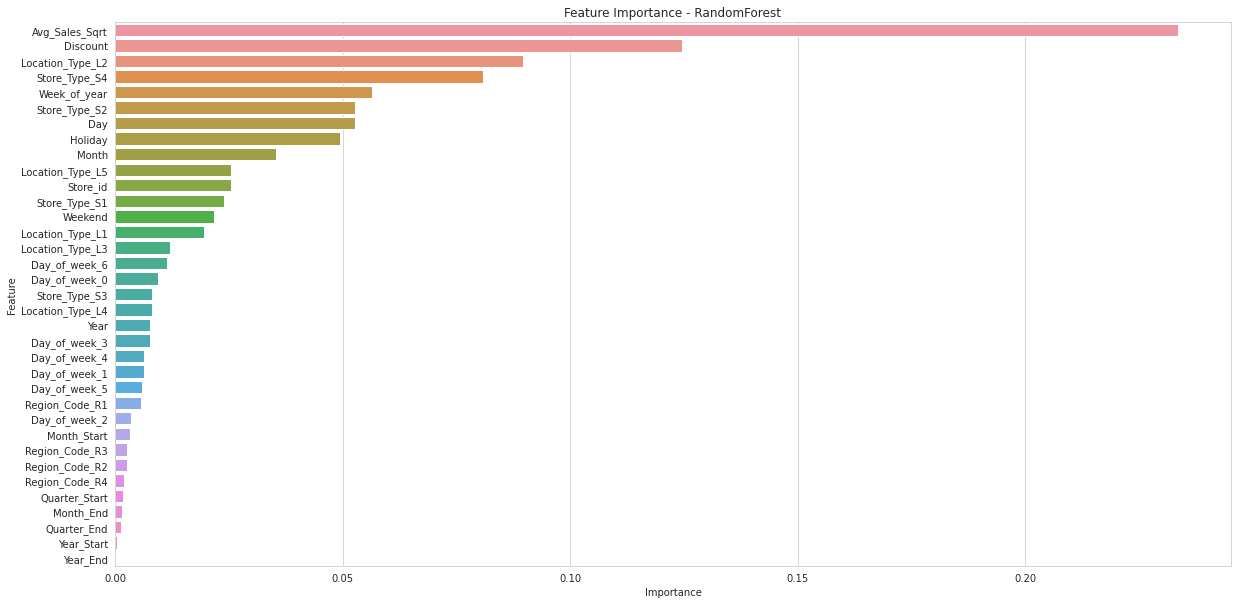

In [0]:
# Feature engineering - creating new features
# logging model - RandomForest with target transformed using sqrt transformation
with mlflow.start_run(run_name = "untuned_random_forest_target_sqrt_transformed_v2"):
  
  # Creating stores avg sales
  train_df["Sales_Sqrt"] = np.sqrt(train_df["Sales"].values)
  Stores_avg_sales = train_df.groupby("Store_id")["Sales_Sqrt"].mean().reset_index()
  Stores_avg_sales.columns = ["Store_id", "Avg_Sales_Sqrt"]
  train_df = pd.merge(train_df, Stores_avg_sales, on = "Store_id", how = "left")
  val_df = pd.merge(val_df, Stores_avg_sales, on = "Store_id", how = "left")
  
  # Creating X and y
  X_train = train_df.drop(["ID", "Sales", "Sales_Sqrt", "Date", "Num_Order", "Period"], axis = 1)
  y_train = train_df["Sales"].values
  
  X_val = val_df.drop(["ID", "Sales", "Date", "Num_Order", "Period"], axis = 1)
  y_val = val_df["Sales"].values
  
  # transforming target variable using sqrt transformation
  y_train_sq_trans = np.sqrt(y_train)
  
  # RandomForest Regression model
  rf_reg_model = \
  Pipeline([('Scaler', StandardScaler()), 
            ('model', RandomForestRegressor(n_estimators = 500, 
                                            min_samples_leaf = 3,
                                            max_features = 'sqrt',
                                            n_jobs = -1,
                                            random_state = 123))
                                                ])

  # fit model
  rf_reg_model = rf_reg_model.fit(X_train, y_train_sq_trans)

  # making prediction
  train_pred = np.square(rf_reg_model.predict(X_train))
  val_pred = np.square(rf_reg_model.predict(X_val))
  
  # calculating score
  train_score = mean_squared_log_error(y_train, train_pred) * 1000
  val_score = mean_squared_log_error(y_val,val_pred) * 1000
  print("training score :", train_score)
  print("validation score :", val_score)

  # Feature importance plot
  importance = rf_reg_model.named_steps["model"].feature_importances_.tolist()
  feature_list = X_train.columns.tolist()

  importance_df = pd.DataFrame()
  importance_df["Feature"] = feature_list
  importance_df["Importance"] = importance

  importance_df = importance_df.sort_values(by = "Importance", ascending = False)

  plt.figure(figsize = (20,10))
  plt.title("Feature Importance - RandomForest")
  sns.barplot(x="Importance", y="Feature", data = importance_df);

  # log hyperparamaters
  mlflow.log_param("n_estimators", 500)
  mlflow.log_param("min_samples_leaf", 3)
  mlflow.log_param("max_features", "sqrt")
  mlflow.log_param("n_jobs", -1)
  mlflow.log_param("random_state", 123)

  # log metric
  mlflow.log_metric("Training MSLE", train_score) 
  mlflow.log_metric("Validation MSLE", val_score)
  
  # log model
  mlflow.sklearn.log_model(rf_reg_model, "RandomForest")

training score : 36.700306862794235


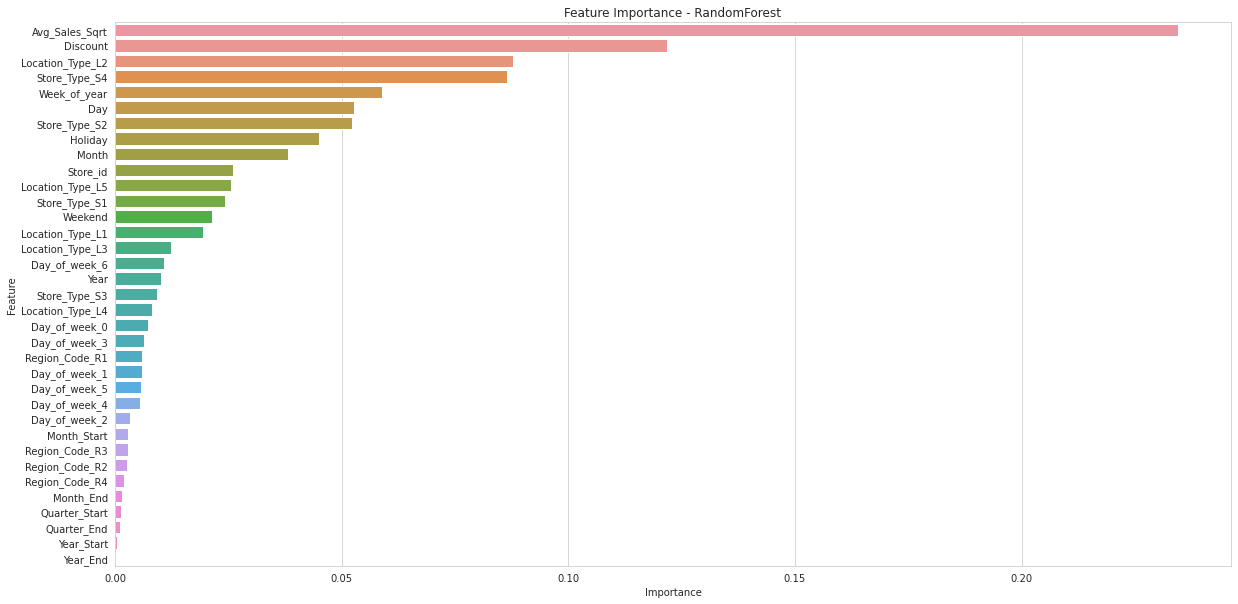

In [0]:
# Feature engineering - creating new features
# logging model - RandomForest with target transformed using sqrt transformation
with mlflow.start_run(run_name = "tuned_random_forest_target_sqrt_transformed_v3"):
  
  # Creating stores avg sales
  train["Sales_Sqrt"] = np.sqrt(train["Sales"].values)
  Stores_avg_sales = train.groupby("Store_id")["Sales_Sqrt"].mean().reset_index()
  Stores_avg_sales.columns = ["Store_id", "Avg_Sales_Sqrt"]
  train = pd.merge(train, Stores_avg_sales, on = "Store_id", how = "left")
  
  # Creating X and y
  X_train = train.drop(["ID", "Sales", "Sales_Sqrt", "Date", "Num_Order", "Period"], axis = 1)
  y_train = train["Sales"].values
  
  # transforming target variable using sqrt transformation
  y_train_sq_trans = np.sqrt(y_train)
  
  # RandomForest Regression model
  rf_reg_model = \
  Pipeline([('Scaler', StandardScaler()), 
            ('model', RandomForestRegressor(n_estimators = 500, 
                                            min_samples_leaf = 3,
                                            max_features = 'sqrt',
                                            n_jobs = -1,
                                            random_state = 123))
                                                ])

  # fit model
  rf_reg_model = rf_reg_model.fit(X_train, y_train_sq_trans)

  # making prediction
  train_pred = np.square(rf_reg_model.predict(X_train))
  
  # calculating score
  train_score = mean_squared_log_error(y_train, train_pred) * 1000
  print("training score :", train_score)

  # Feature importance plot
  importance = rf_reg_model.named_steps["model"].feature_importances_.tolist()
  feature_list = X_train.columns.tolist()

  importance_df = pd.DataFrame()
  importance_df["Feature"] = feature_list
  importance_df["Importance"] = importance

  importance_df = importance_df.sort_values(by = "Importance", ascending = False)

  plt.figure(figsize = (20,10))
  plt.title("Feature Importance - RandomForest")
  sns.barplot(x="Importance", y="Feature", data = importance_df);

  # log hyperparamaters
  mlflow.log_param("n_estimators", 500)
  mlflow.log_param("min_samples_leaf", 3)
  mlflow.log_param("max_features", "sqrt")
  mlflow.log_param("n_jobs", -1)
  mlflow.log_param("random_state", 123)

  # log metric
  mlflow.log_metric("Training MSLE", train_score) 
  
  # log model
  mlflow.sklearn.log_model(rf_reg_model, "RandomForest")

training score : 31.505750832254236


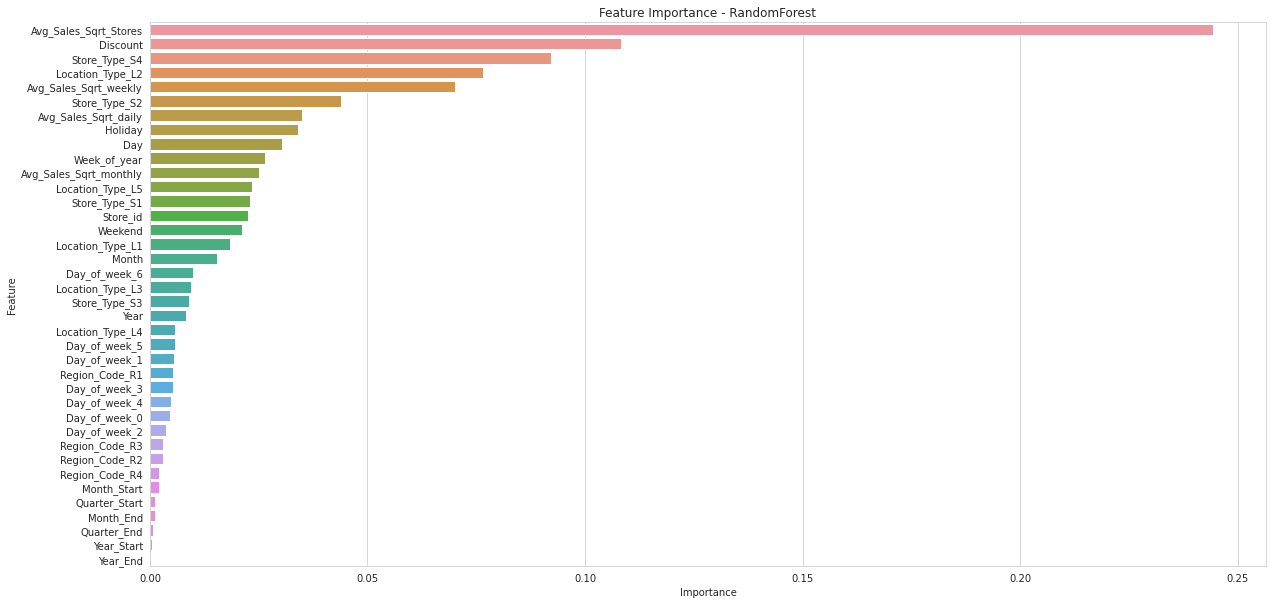

In [0]:
# Feature engineering - creating new features
# logging model - RandomForest with target transformed using sqrt transformation
with mlflow.start_run(run_name = "tuned_random_forest_target_sqrt_transformed_v5"):
  
  # Creating stores avg sales
  train["Sales_Sqrt"] = np.sqrt(train["Sales"].values)
  Stores_avg_sales = train.groupby("Store_id")["Sales_Sqrt"].mean().reset_index()
  Stores_avg_sales.columns = ["Store_id", "Avg_Sales_Sqrt_Stores"]
  train = pd.merge(train, Stores_avg_sales, on = "Store_id", how = "left")
  
  # Creating weekly avg sales
  Weekly_avg_sales = train.groupby("Week_of_year")["Sales_Sqrt"].mean().reset_index()
  Weekly_avg_sales.columns = ["Week_of_year", "Avg_Sales_Sqrt_weekly"]
  train = pd.merge(train, Weekly_avg_sales, on = "Week_of_year", how = "left")
  
  # Creating monthly avg sales
  monthly_avg_sales = train.groupby("Month")["Sales_Sqrt"].mean().reset_index()
  monthly_avg_sales.columns = ["Month", "Avg_Sales_Sqrt_monthly"]
  train = pd.merge(train, monthly_avg_sales, on = "Month", how = "left")
  
  # Creating daily avg sales
  daily_avg_sales = train.groupby("Day")["Sales_Sqrt"].mean().reset_index()
  daily_avg_sales.columns = ["Day", "Avg_Sales_Sqrt_daily"]
  train = pd.merge(train, daily_avg_sales, on = "Day", how = "left")
  
  # Creating X and y
  X_train = train.drop(["ID", "Sales", "Sales_Sqrt", "Date", "Num_Order", "Period"], axis = 1)
  y_train = train["Sales"].values
  
  # transforming target variable using sqrt transformation
  y_train_sq_trans = np.sqrt(y_train)
  
  # RandomForest Regression model
  rf_reg_model = \
  Pipeline([('Scaler', StandardScaler()), 
            ('model', RandomForestRegressor(n_estimators = 500, 
                                            min_samples_leaf = 3,
                                            max_features = 'sqrt',
                                            n_jobs = -1,
                                            random_state = 123))
                                                ])

  # fit model
  rf_reg_model = rf_reg_model.fit(X_train, y_train_sq_trans)

  # making prediction
  train_pred = np.square(rf_reg_model.predict(X_train))
  
  # calculating score
  train_score = mean_squared_log_error(y_train, train_pred) * 1000
  print("training score :", train_score)

  # Feature importance plot
  importance = rf_reg_model.named_steps["model"].feature_importances_.tolist()
  feature_list = X_train.columns.tolist()

  importance_df = pd.DataFrame()
  importance_df["Feature"] = feature_list
  importance_df["Importance"] = importance

  importance_df = importance_df.sort_values(by = "Importance", ascending = False)

  plt.figure(figsize = (20,10))
  plt.title("Feature Importance - RandomForest")
  sns.barplot(x="Importance", y="Feature", data = importance_df);

  # log hyperparamaters
  mlflow.log_param("n_estimators", 500)
  mlflow.log_param("min_samples_leaf", 3)
  mlflow.log_param("max_features", "sqrt")
  mlflow.log_param("n_jobs", -1)
  mlflow.log_param("random_state", 123)

  # log metric
  mlflow.log_metric("Training MSLE", train_score) 
  
  # log model
  mlflow.sklearn.log_model(rf_reg_model, "RandomForest")

training score : 32.79905457974129


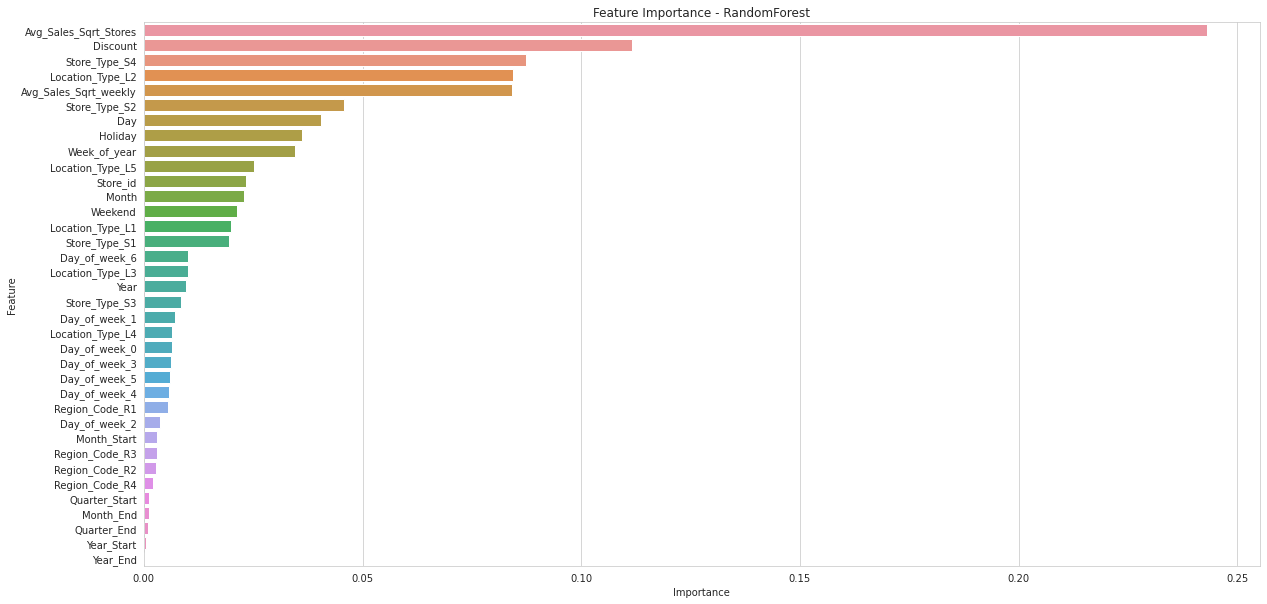

In [0]:
# Feature engineering - creating new features
# logging model - RandomForest with target transformed using sqrt transformation
with mlflow.start_run(run_name = "tuned_random_forest_target_sqrt_transformed_v6"):
  
  # Creating stores avg sales
  train["Sales_Sqrt"] = np.sqrt(train["Sales"].values)
  Stores_avg_sales = train.groupby("Store_id")["Sales_Sqrt"].mean().reset_index()
  Stores_avg_sales.columns = ["Store_id", "Avg_Sales_Sqrt_Stores"]
  train = pd.merge(train, Stores_avg_sales, on = "Store_id", how = "left")
  
  # Creating weekly avg sales
  Weekly_avg_sales = train.groupby("Week_of_year")["Sales_Sqrt"].mean().reset_index()
  Weekly_avg_sales.columns = ["Week_of_year", "Avg_Sales_Sqrt_weekly"]
  train = pd.merge(train, Weekly_avg_sales, on = "Week_of_year", how = "left")
  
  # Creating X and y
  X_train = train.drop(["ID", "Sales", "Sales_Sqrt", "Date", "Num_Order", "Period"], axis = 1)
  y_train = train["Sales"].values
  
  # transforming target variable using sqrt transformation
  y_train_sq_trans = np.sqrt(y_train)
  
  # RandomForest Regression model
  rf_reg_model = \
  Pipeline([('Scaler', StandardScaler()), 
            ('model', RandomForestRegressor(n_estimators = 500, 
                                            min_samples_leaf = 3,
                                            max_features = 'sqrt',
                                            n_jobs = -1,
                                            random_state = 123))
                                                ])

  # fit model
  rf_reg_model = rf_reg_model.fit(X_train, y_train_sq_trans)

  # making prediction
  train_pred = np.square(rf_reg_model.predict(X_train))
  
  # calculating score
  train_score = mean_squared_log_error(y_train, train_pred) * 1000
  print("training score :", train_score)

  # Feature importance plot
  importance = rf_reg_model.named_steps["model"].feature_importances_.tolist()
  feature_list = X_train.columns.tolist()

  importance_df = pd.DataFrame()
  importance_df["Feature"] = feature_list
  importance_df["Importance"] = importance

  importance_df = importance_df.sort_values(by = "Importance", ascending = False)

  plt.figure(figsize = (20,10))
  plt.title("Feature Importance - RandomForest")
  sns.barplot(x="Importance", y="Feature", data = importance_df);

  # log hyperparamaters
  mlflow.log_param("n_estimators", 500)
  mlflow.log_param("min_samples_leaf", 3)
  mlflow.log_param("max_features", "sqrt")
  mlflow.log_param("n_jobs", -1)
  mlflow.log_param("random_state", 123)

  # log metric
  mlflow.log_metric("Training MSLE", train_score) 
  
  # log model
  mlflow.sklearn.log_model(rf_reg_model, "RandomForest")

#### Making Inference

In [0]:
test_new = pd.merge(test, Stores_avg_sales, on = "Store_id", how = "left")
test_new = pd.merge(test_new, Weekly_avg_sales, on = "Week_of_year", how = "left")

# Creating X and y
X_new = test_new.drop(["ID", "Date", "Period"], axis = 1)
predictions = np.square(rf_reg_model.predict(X_new))

val_df_pred = test_new.copy()
val_df_pred["Sales"] = predictions
val_df_pred_fin = val_df_pred[["ID", "Sales"]]

In [0]:
display(val_df_pred_fin)

ID,Sales
T1188341,64116.83471530383
T1188342,44619.77945874352
T1188343,87267.51611607874
T1188344,41734.51776717996
T1188345,45950.29684352907
T1188346,102765.55150782022
T1188347,75413.1089649068
T1188348,55614.69821822468
T1188349,62471.921256626956
T1188350,36689.60856191124


In [0]:
display(val_df_pred_fin)

ID,Sales
T1188341,63425.80268517662
T1188342,43894.27423905341
T1188343,86244.85158176303
T1188344,41747.478716478334
T1188345,44951.00442153657
T1188346,99406.44767789205
T1188347,73257.64551781079
T1188348,55878.06602776036
T1188349,62473.4037429487
T1188350,37805.36890235404


In [0]:
test_new = pd.merge(test, Stores_avg_sales, on = "Store_id", how = "left")
  
# Creating X and y
X_new = test_new.drop(["ID", "Date", "Period"], axis = 1)
predictions = np.square(rf_reg_model.predict(X_new))

val_df_pred = test_new.copy()
val_df_pred["Sales"] = predictions
val_df_pred_fin = val_df_pred[["ID", "Sales"]]

In [0]:
display(val_df_pred_fin)

ID,Sales
T1188341,61483.45261166203
T1188342,43019.0946621292
T1188343,84034.30422839492
T1188344,39796.416155186525
T1188345,44416.36166478321
T1188346,100142.62738453026
T1188347,73401.69916116352
T1188348,52799.968056325866
T1188349,58565.77291637276
T1188350,36097.651212239274


In [0]:
# making predictions
X_test = test.drop(["ID", "Date", "Period"], axis = 1)
predictions = np.square(rf_reg_model.predict(X_test))

val_df_pred = test.copy()
val_df_pred["Sales"] = predictions
val_df_pred_fin = val_df_pred[["ID", "Sales"]]

In [0]:
# Viewing and downloading predictions
display(val_df_pred_fin)

ID,Sales
T1188341,67398.89912908679
T1188342,41058.219197526436
T1188343,81225.67402941115
T1188344,40472.84750172951
T1188345,42099.00733157132
T1188346,82881.51167548036
T1188347,68340.81718273909
T1188348,51868.04788478002
T1188349,58617.37017641657
T1188350,36181.779005486875
